# 動的一般化線形モデル(DGLM)

動的一般化線形モデルは一般化線形モデル(GLM)と動的線形モデル(DLM)の拡張であると言える。GLMの観点からは、線形予測子がDLMで想定しているさまざまな構造から成り立っており、DLMの観点からは、観測方程式が正規分布以外を仮定している場合であると考えられる。

一般的なDLMの例であるローカルレベルモデルと1次のトレンドを用いた基本構造時系列モデルは次のようになる。
$$
\gamma_t \sim Normal\Bigl(-\sum_{t-(k-1)}^{t-1}\gamma_i, \sigma_s^2\Bigr) \\
\mu_t \sim Normal(\mu_{t-1}, \sigma_w^2) \\
y_t \sim Normal(\mu_t+\gamma_t, \sigma_v^2)
$$
ここでは、観測方程式の確率分布として正規分布を過程しているが、DGLMでは次のように観測方程式にポアソン分布や二項分布を仮定できる。
$$
y_t \sim Poisson(\exp(\mu_t+\gamma_t)) \\
y_t \sim Bernoulli(logistic(\mu_t+\gamma_t)) \\
$$
ここでは、二項分布とポアソン分布によるDGLMを実装する。

## 二項分布を仮定したDGLM

次のようにローカルレベルモデル(1次のトレンド)と二項分布によるDGLMを考える。
$$
\mu_t \sim Normal(\mu_{t-1}, \sigma_w^2) \\
y_t \sim Bernoulli(logistic(\mu_t)) \\
$$
オックスフォード大学とケンブリッジ大学のボートレースのデータを分析する。1年に一回取られたデータで、0ならオックスフォード、1ならケンブリッジが買ったことを表している。

In [2]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

import stan
import nest_asyncio
nest_asyncio.apply()

In [28]:
boat = pd.read_csv('../data/4-8-1-boat.csv')
boat["year"] = [datetime.strptime(str(i+1828), "%Y") for i in boat["year"]]

In [15]:
T = len(boat)
y = boat[~boat["x"].isnull()]["x"].values.astype(int)
len_obs = T - sum(boat["x"].isnull())
obs_no = boat[~boat["x"].isnull()].index.values + 1

In [17]:
stan_data = {
    "y": y,
    "T": T,
    "len_obs": len_obs,
    "obs_no": obs_no
}

In [18]:
with open("../stan/4-8-1-dglm-binom.stan", "r") as f:
    stan_code = f.read()

In [19]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...



Building: found in cache, done.

In [20]:
fit = sm.sample(num_chains=3, num_samples=9000, num_warmup=1000, num_thin=3)

Sampling:   0%
Sampling:   0% (1/30000)
Sampling:   0% (2/30000)
Sampling:   0% (3/30000)
Sampling:   1% (202/30000)
Sampling:   1% (401/30000)
Sampling:   2% (600/30000)
Sampling:   3% (1000/30000)
Sampling:   4% (1200/30000)
Sampling:   5% (1400/30000)
Sampling:   5% (1500/30000)
Sampling:   5% (1600/30000)
Sampling:   6% (1900/30000)
Sampling:   7% (2000/30000)
Sampling:   7% (2200/30000)
Sampling:   8% (2400/30000)
Sampling:  11% (3300/30000)
Sampling:  42% (12600/30000)
Sampling:  72% (21700/30000)
Sampling:  78% (23300/30000)
Sampling:  78% (23500/30000)
Sampling:  82% (24700/30000)
Sampling:  85% (25600/30000)
Sampling:  93% (27800/30000)
Sampling:  97% (29100/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Gradient evaluation took 0.000168 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.68 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.1e-05 seconds
  1000 

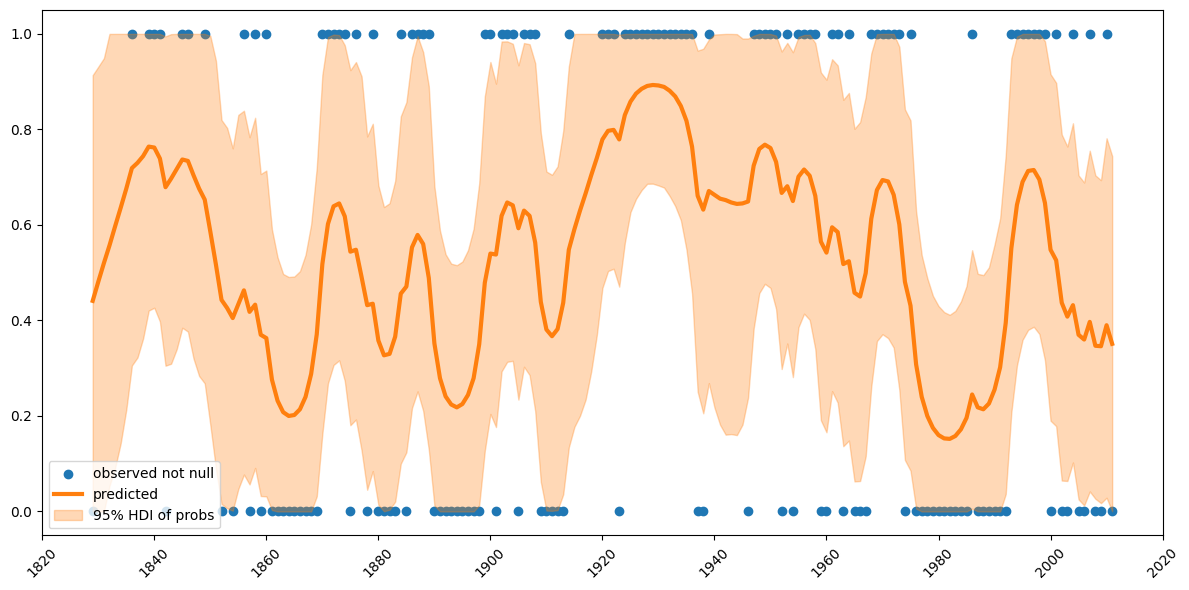

In [30]:
cmap = plt.get_cmap("tab10")

hdis = az.hdi(fit, hdi_prob=0.95)["probs"].values
probs_mean = az.summary(fit, var_names=["probs"])["mean"].values

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.scatter(boat["year"], boat["x"], color=cmap(0), label="observed not null")
axes.plot(boat["year"], probs_mean, color=cmap(1), label="predicted", lw=3)
axes.fill_between(boat["year"], y1=hdis[:,0], y2=hdis[:,1], color=cmap(1), alpha=0.30, label="95% HDI of probs")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

このようにオックスフォードとケンブリッジ大学の勝率は期間によって変化していることがわかる。ちなみに全期間の平均をとるとケンブリッジ大学の平均勝率はやく52%となり、ほとんど実力が拮抗していることになってしまう。

In [31]:
boat["x"].mean()

0.5161290322580645

## ポアソン分布を仮定したDGLM

ここでは気温と釣果の関係を時系列を考慮することで調べる。次のように平坦化トレンドモデル(2次のトレンド)とポアソン分布を仮定して、モデル化する。
$$
r_t \sim Normal(0, \sigma_r^2) \\
\mu_t \sim Normal(2\mu_{t-1}-\mu_{t-2}, \sigma_\zeta^2) \\
\lambda_t = \mu_t + \beta x_t + r_t \\
y_t \sim Poisson(exp(\lambda_t))
$$
ここでは過分散を防ぐためにランダム効果$r_t$を組み込んでいる。

In [3]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

import stan
import nest_asyncio
nest_asyncio.apply()

In [4]:
fish_num = pd.read_csv('../data/4-8-2-fish-num.csv')
fish_num['date'] = [datetime.strptime(i, "%Y-%m-%d") for i in fish_num["date"]]

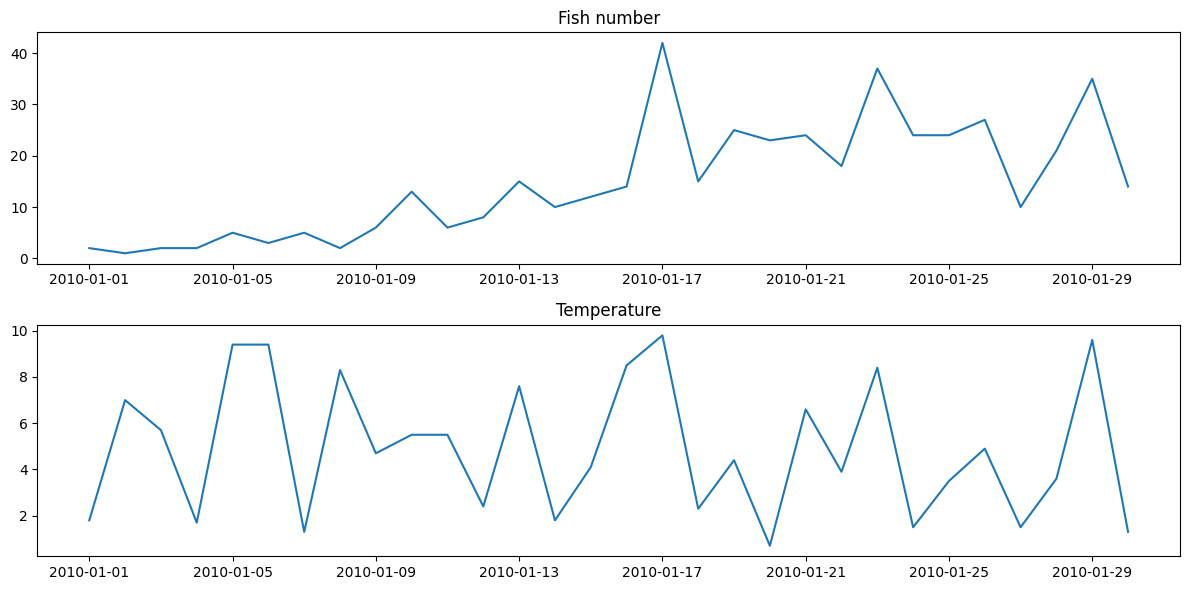

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].plot(fish_num["date"], fish_num["fish_num"])
axes[1].plot(fish_num["date"], fish_num["temperature"])

axes[0].set_title("Fish number")
axes[1].set_title("Temperature")
plt.tight_layout()

In [6]:
T = len(fish_num)
y = fish_num["fish_num"].values
ex = fish_num["temperature"].values

In [7]:
stan_data = {
    "T": T,
    "y": y,
    "ex": ex
}

In [8]:
with open('../stan/4-8-2-dglm-poisson.stan') as f:
    stan_code = f.read()

In [9]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [10]:
fit = sm.sample(num_chains=3, num_samples=9000, num_warmup=1000, num_thin=3)

Sampling:   0%
Sampling:   1% (300/30000)
Sampling:   3% (800/30000)
Sampling:   4% (1300/30000)
Sampling:  37% (11000/30000)
Sampling:  68% (20500/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Gradient evaluation took 0.000106 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_f74r_2l5/model_wobchlge.stan', line 26, col

In [13]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,lambda_smooth_fix.21,lambda_smooth_fix.22,lambda_smooth_fix.23,lambda_smooth_fix.24,lambda_smooth_fix.25,lambda_smooth_fix.26,lambda_smooth_fix.27,lambda_smooth_fix.28,lambda_smooth_fix.29,lambda_smooth_fix.30
draws,,,,,,,,,,,,,,,,,,,,,
0,936.400594,0.995784,0.052836,6.0,63.0,0.0,-901.179355,0.044458,-0.071193,-0.055842,...,18.897509,21.277048,24.357788,28.195543,28.248880,24.483059,21.804028,19.473261,18.156680,25.052222
1,974.805089,0.965732,0.017308,9.0,511.0,0.0,-944.620807,0.858404,0.910595,0.950786,...,24.100254,25.657763,27.284931,27.587233,27.982366,28.220328,28.389315,28.786487,28.327422,28.357300
2,997.710919,0.944610,0.036780,5.0,31.0,0.0,-968.190093,-1.150828,-0.902234,-0.458598,...,25.343999,26.230874,26.848364,26.851931,26.346961,23.647814,20.135464,19.058309,18.518674,18.754943
3,945.756104,0.975332,0.052836,7.0,191.0,0.0,-918.348889,-0.439467,-0.203087,0.061851,...,27.375198,25.284180,26.175119,26.732762,26.518537,26.224727,22.491222,22.083342,17.530992,15.265056
4,978.709407,0.983230,0.017308,8.0,255.0,0.0,-955.788194,0.244806,0.468310,0.673588,...,23.327881,24.981767,25.749049,26.638234,27.611062,28.034096,28.482926,27.840213,27.723423,27.151884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,993.006534,0.895459,0.017308,8.0,255.0,0.0,-963.916967,-0.129700,0.024778,0.169304,...,25.437312,25.178994,24.754180,24.097685,23.260641,22.594613,21.045808,19.903184,19.007368,17.631654
8996,960.814690,0.653581,0.036780,7.0,127.0,0.0,-934.928264,0.087307,0.263530,0.459689,...,20.980949,20.777596,20.942530,20.163682,20.018857,21.204315,22.256458,24.220944,27.856428,32.755848
8997,950.889042,0.966515,0.052836,7.0,127.0,0.0,-920.704435,-0.071252,0.181716,0.331515,...,31.314599,33.134518,33.627229,32.501848,28.917363,25.804799,23.540567,21.581231,19.219619,15.374549


In [16]:
hdi_lambda_smooth[:,1]

<xarray.DataArray 'lambda_smooth' (lambda_smooth_dim_0: 30)> Size: 240B
array([ 2.10749576,  3.3764584 ,  3.29203059,  2.76193526,  5.79708776,
        6.77316656,  4.21163046,  8.53646597,  7.45536755,  9.56638147,
       11.12440738, 10.33215453, 17.8692826 , 13.07771557, 17.2676866 ,
       28.55875651, 36.39955513, 21.80648875, 27.55283462, 22.12043688,
       35.58837622, 28.5533641 , 43.44568709, 24.94217911, 28.25965559,
       30.96412958, 27.2478394 , 30.23831147, 43.25121386, 29.13228562])
Coordinates:
  * lambda_smooth_dim_0  (lambda_smooth_dim_0) int64 240B 0 1 2 3 ... 27 28 29
    hdi                  <U6 24B 'higher'

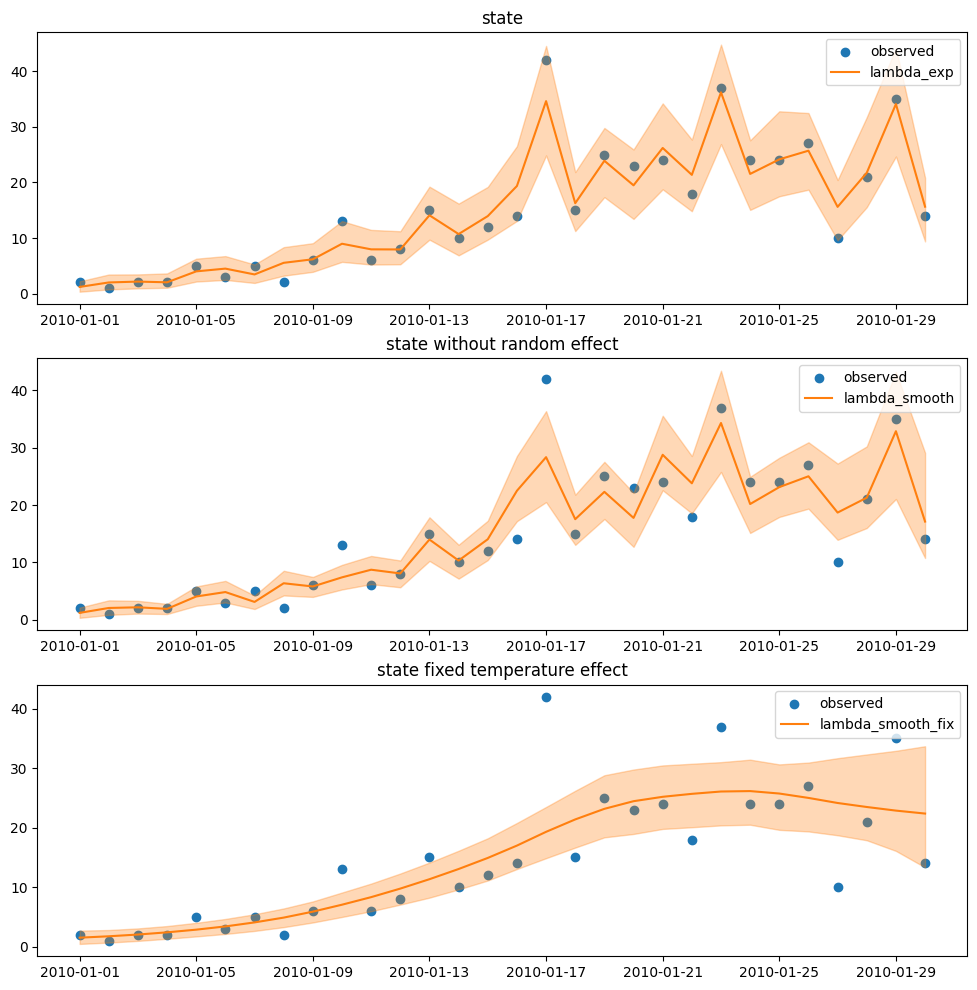

In [19]:
cmap = plt.get_cmap("tab10")

lambda_exp_mean = az.summary(fit, var_names=["lambda_exp"])["mean"].values
lambda_smooth_mean = az.summary(fit, var_names=["lambda_smooth"])["mean"].values
lambda_smooth_fix_mean = az.summary(fit, var_names=["lambda_smooth_fix"])["mean"].values


hdis = az.hdi(fit, var_names=["lambda_smooth", "lambda_smooth_fix", "lambda_exp"], hdi_prob=0.95)
hdi_lambda_smooth = hdis["lambda_smooth"].values
hdi_lambda_smooth_fix = hdis["lambda_smooth_fix"].values
hdi_lambda_exp = hdis["lambda_exp"].values

fig, axes = plt.subplots(3, 1, figsize=(12, 12))
axes[0].scatter(fish_num["date"], fish_num["fish_num"], color=cmap(0), label="observed")
axes[1].scatter(fish_num["date"], fish_num["fish_num"], color=cmap(0), label="observed")
axes[2].scatter(fish_num["date"], fish_num["fish_num"], color=cmap(0), label="observed")

axes[0].plot(fish_num["date"], lambda_exp_mean, color=cmap(1), label="lambda_exp")
axes[1].plot(fish_num["date"], lambda_smooth_mean, color=cmap(1), label="lambda_smooth")
axes[2].plot(fish_num["date"], lambda_smooth_fix_mean, color=cmap(1), label="lambda_smooth_fix")

axes[0].fill_between(fish_num["date"], hdi_lambda_exp[:, 0], hdi_lambda_exp[:, 1], color=cmap(1), alpha=0.3)
axes[1].fill_between(fish_num["date"], hdi_lambda_smooth[:, 0], hdi_lambda_smooth[:, 1], color=cmap(1), alpha=0.3)
axes[2].fill_between(fish_num["date"], hdi_lambda_smooth_fix[:, 0], hdi_lambda_smooth_fix[:, 1], color=cmap(1), alpha=0.3)

axes[0].set_title("state")
axes[1].set_title("state without random effect")
axes[2].set_title("state fixed temperature effect")

axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.legend()
plt.show()

気温を固定した場合を見ると時間が経つごとに釣果が増えているので、何かしらの要因で釣果が増えることがわかる。